## Version 4, as I'm going to start implementing the exercises

### E01 was just to adjust the hyperparameters, and it really does improve the loss and produces way better results!

### E02 I am still confused about.

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import random
%matplotlib inline

In [51]:
words = open('../names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

### Knobs for tuning hyperparameters

In [52]:
len_context = 3 
nneurons = 400
emb_dim = 20
batch_size = 64

In [53]:
def build_dataset(words, block_size):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    # split up dataset
    random.seed(42)
    random.shuffle(words)
    n1 = int(0.8*X.shape[0])
    n2 = int(0.9*X.shape[0])
    Xtr, Xdev, Xte = X.tensor_split((n1, n2), dim=0)
    Ytr, Ydev, Yte = Y.tensor_split((n1, n2), dim=0)
    
    return Xtr, Ytr, Xdev, Ydev, Xte, Yte 

Xtr, Ytr, Xdev, Ydev, Xte, Yte = build_dataset(words, len_context)
Xtr.shape, Ytr.shape, Xdev.shape, Ydev.shape, Xte.shape, Yte.shape

(torch.Size([182516, 3]),
 torch.Size([182516]),
 torch.Size([22815, 3]),
 torch.Size([22815]),
 torch.Size([22815, 3]),
 torch.Size([22815]))

In [54]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(27, emb_dim, generator=g)
W1 = torch.randn((len_context*emb_dim, nneurons), generator=g)
b1 = torch.randn(nneurons, generator=g)
W2 = torch.randn((nneurons, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
print(f'total parameters: {sum(p.nelement() for p in parameters)}')
for p in parameters:
    p.requires_grad = True
    p.grad = None

total parameters: 35767


In [55]:
lossi = []
stepi = []

In [3]:
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini-batch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, emb.shape[1]*emb.shape[2]) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < int(max_size/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10_000 == 0:
        print(f'loss at step {i}: {loss:.4f}')
    lossi.append(loss.log10().item())
    stepi.append(i)
    
print(f'-----\nfinal loss: {10**(lossi[-1])}')

NameError: name 'Xtr' is not defined

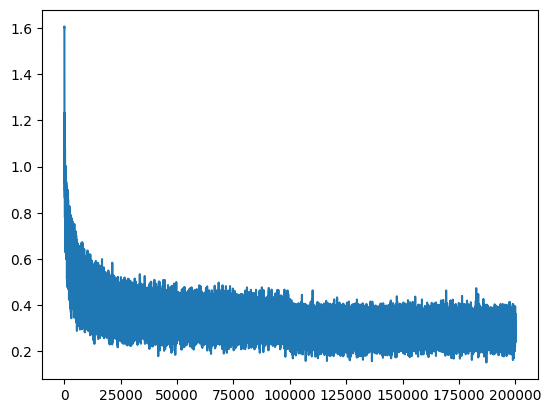

In [44]:
plt.plot(stepi, lossi)

In [45]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, emb.shape[1]*emb.shape[2]) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.9973, grad_fn=<NllLossBackward0>)

In [46]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, emb.shape[1]*emb.shape[2]) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1777, grad_fn=<NllLossBackward0>)

### Test your model out

In [48]:
g = torch.Generator().manual_seed(2147483647+10)
block_size = 3 # this should be initialized earlier

for _ in range(20):
    out = []
    context = [0] * block_size
    
    while True:
        emb = C[torch.tensor([context])] # (1, contextsize)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

montaymyah.
see.
mad.
ryllo.
emmadiendra.
gradelynnelin.
shi.
jen.
eden.
van.
aaraelyziry.
kalin.
shur.
ridhimie.
trick.
welle.
xabius.
kus.
mace.
raylynn.
